In [14]:
import mido 

#inport = mido.open_input('Akai MPD32')

inport = mido.open_input('OCTA-CAPTURE MIDI')


In [15]:
mido.get_input_names()


['Akai MPD32', 'Akai MPD32 Port 3', 'OCTA-CAPTURE CTRL', 'OCTA-CAPTURE MIDI']

In [16]:
import time

In [37]:
listmsg = []

starttime = time.time()

while True:
    for msg in inport.iter_pending():
        listmsg.append([msg,time.time()-starttime])

KeyboardInterrupt: 

In [38]:
import numpy as np
print(len(listmsg))
np.savez_compressed('temp.npz',list=listmsg)

1233


In [95]:
listmsg

[]

In [39]:
import numpy as np 

focus = []
subjtime=[]
notes = []

absolute_start =listmsg[0][1]

for curmsg,curt in listmsg:
    if curmsg.type is 'control_change':

        if curmsg.control == 20:
            focus.append([curt-absolute_start,curmsg.value])
        elif curmsg.control == 22:
            subjtime.append([curt-absolute_start,curmsg.value])
    elif curmsg.type is 'note_on':
        notes.append([curt-absolute_start,curmsg.note])

focus = np.stack(focus)
subjtime = np.stack(subjtime)
notes = np.stack(notes)

In [40]:
notes.shape

(1, 2)

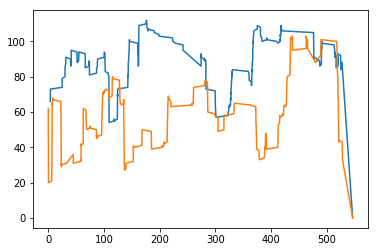

In [41]:
import matplotlib.pyplot as plt 
%matplotlib inline 
plt.plot(focus[:,0],focus[:,1])
plt.plot(subjtime[:,0],subjtime[:,1])

In [42]:
def quantize(vector,res=0.3,endtime=2,delaytime=1):
    vectimes = vector[:,0]
    maxtime = max(vectimes)
    
    alltimes = np.arange(0,maxtime-endtime,res)
    
    qvec = []
    ## loop over all time segments between two instants of length "res"
    
    prev_val = vector[0,1]
    
    for i,curtime in enumerate(alltimes[:-2]):
        
        ind = np.argwhere((vectimes>curtime) & (vectimes<alltimes[i+1]))
        
        if len(ind)==0:
            qvec.append([curtime,prev_val])
        else:
            qvec.append([curtime,np.mean(vector[ind,1])])
            prev_val = np.mean(vector[ind,1])
    return np.stack(qvec) + np.repeat(np.array([[delaytime],[0]]),len(qvec),axis=1).T
    
focus_q = quantize(focus,res=1,delaytime=0)
subt_q = quantize(subjtime,res=1,delaytime=1)
notes_q = quantize(notes,res=1,delaytime=0)

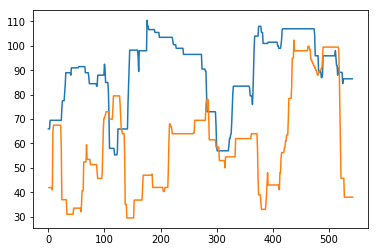

In [43]:
plt.plot(focus_q[:,0],focus_q[:,1])
plt.plot(subt_q[:,0],subt_q[:,1])

In [44]:
np.savez_compressed('caroleeg_sess4_1.npz',focus=focus,subjtime=subjtime,notes=notes,focus_q=focus_q,subt_q=subt_q,notes_q = notes)





In [26]:
focus_q.shape

(594, 2)

In [36]:
np.load('caroleeg_sess3_2.npz')['focus'].shape

(254, 2)

Simple visualization

In [24]:
!ls

Analysis_eegsynth.ipynb           caroleeg_sess3_3.npz
Analysis_sessionswithBitwig.ipynb data
LICENSE                           data.zip
README.md                         datarob
RecordFromBitwig.ipynb            datarob.zip
Untitled.ipynb                    dump.rdb
caroleeg_sess3.npz                eeg_quicklook.ipynb
caroleeg_sess3_2.npz              temp.npz


In [80]:
minlen = min(focus_q.shape[0],subt_q.shape[0])

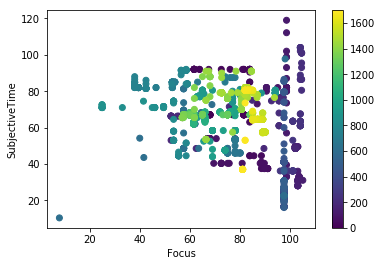

In [81]:
plt.scatter(focus_q[:minlen,1],subt_q[:minlen,1],c=focus_q[:minlen,0])
plt.xlabel('Focus')
plt.ylabel('SubjectiveTime')
plt.colorbar()